In [146]:
#import required libs
import torch.nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
from visualize import visualize
import json

%matplotlib inline

In [147]:
inceptionv3 = models.inception_v3(weights="DEFAULT") #download and load pretrained inceptionv3 model
inceptionv3.eval()

img = Image.open("../data/images/cat.jpg")

#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

image_tensor = preprocess(img) #preprocess an i
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W

img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

In [148]:
output = inceptionv3.forward(img_variable)
label_idx = torch.max(output.data, 1)[1].numpy()[0]   #get an index(class number) of a largest element
print(label_idx)

282


In [149]:
# labels_link = ""    
# labels_json = requests.get(labels_link).json()
labels_json = json.load(open("../data/attack/labels.json", "r"))
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx]
print(x_pred)

tiger cat


In [150]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob =  round((torch.max(output_probs.data, 1)[0].numpy()[0]) * 100,4)
print(x_pred_prob)

77.4909


In [151]:
y_true = 282   #tiger cat  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([282])


In [152]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

In [153]:
eps = 0.001
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = inceptionv3.forward(Variable(x_adversarial))   #perform a forward pass on adv example
x_adv_pred = labels[torch.max(output_adv.data, 1)[1].numpy()[0]]    #classify the adv example
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0].numpy()[0]) * 100, 4)  

print(x_adv_pred)
print(adv_pred_prob)#find probability (confidence) of a predicted class

tiger cat
64.5472


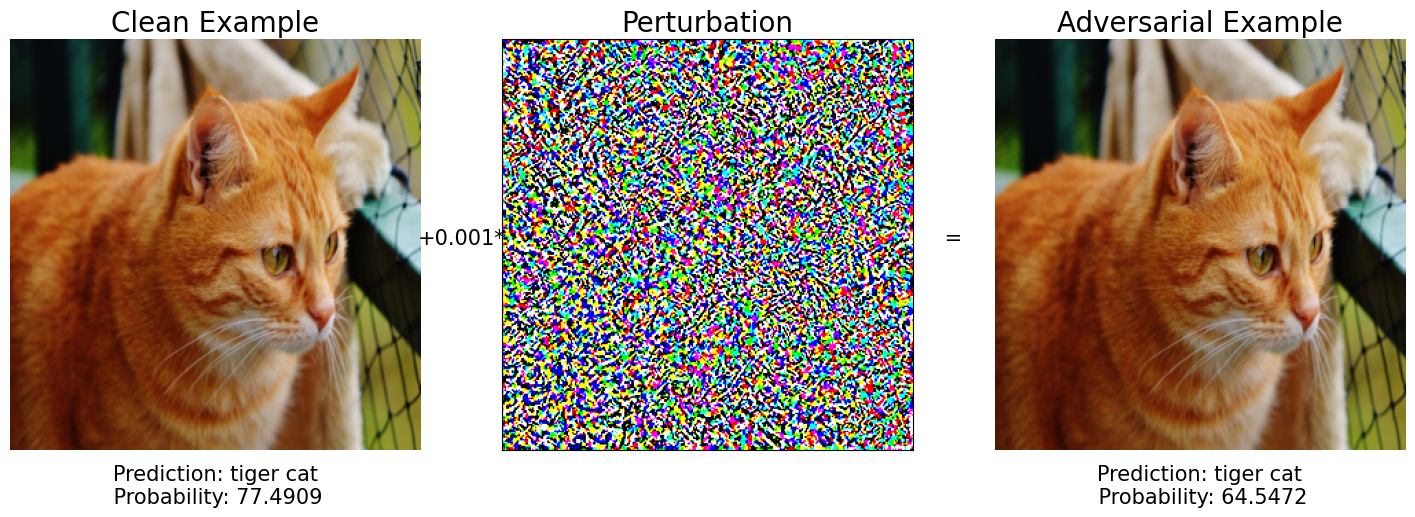

In [155]:
visualize(image_tensor, x_adversarial, mean, std, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

In [140]:
epsilon = [0.00088, 0.004, 0.01, 0.12, 0.55]

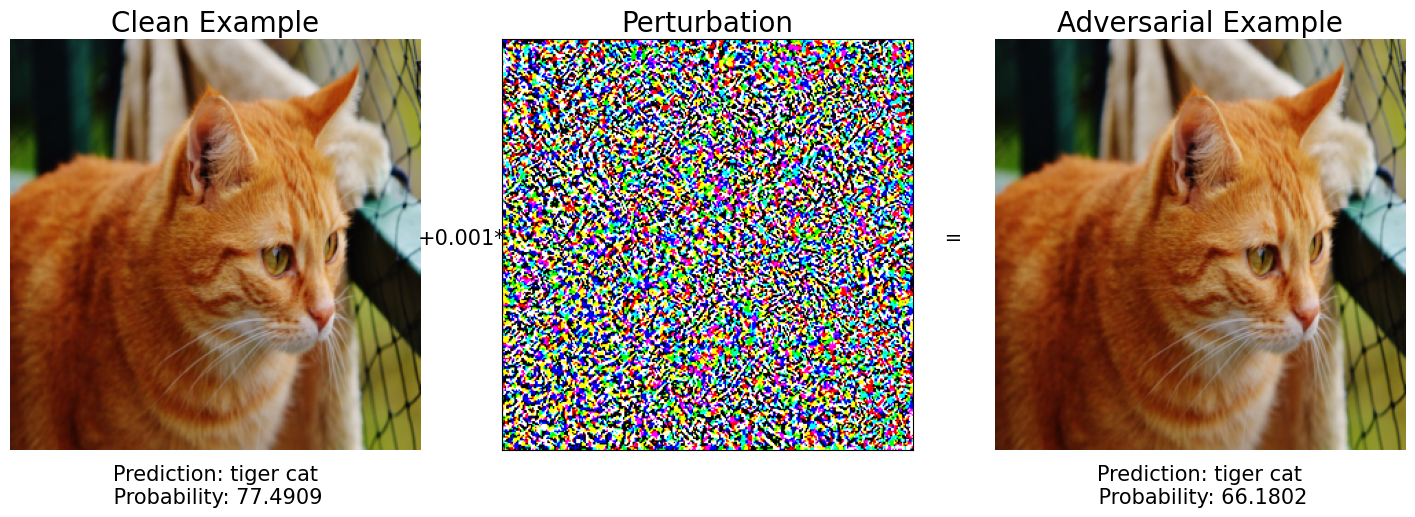

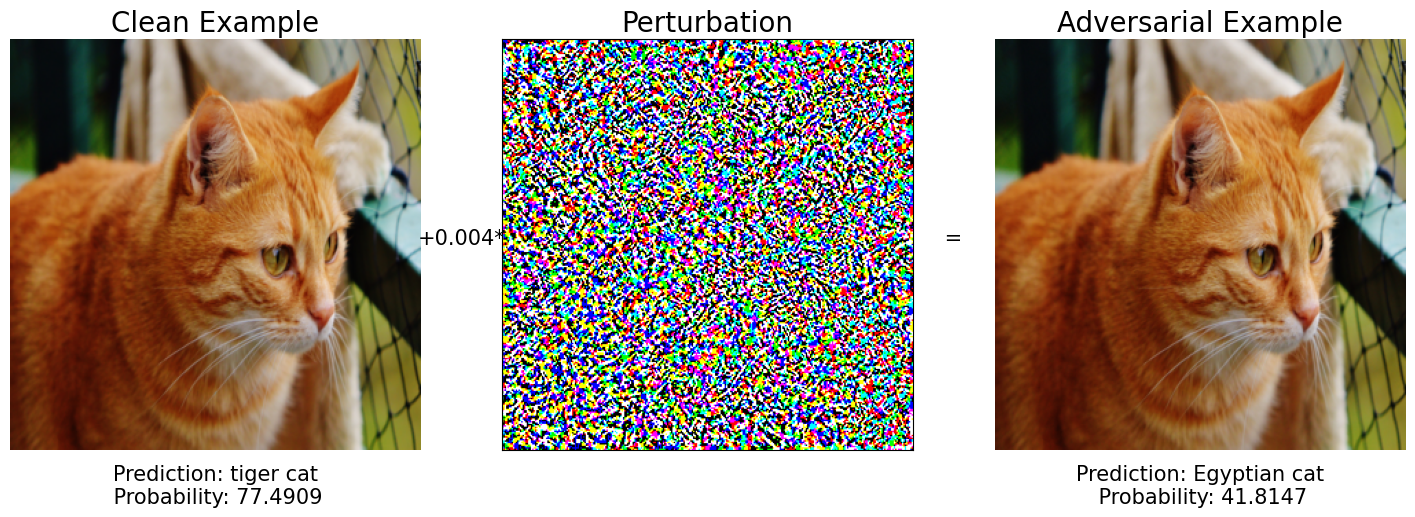

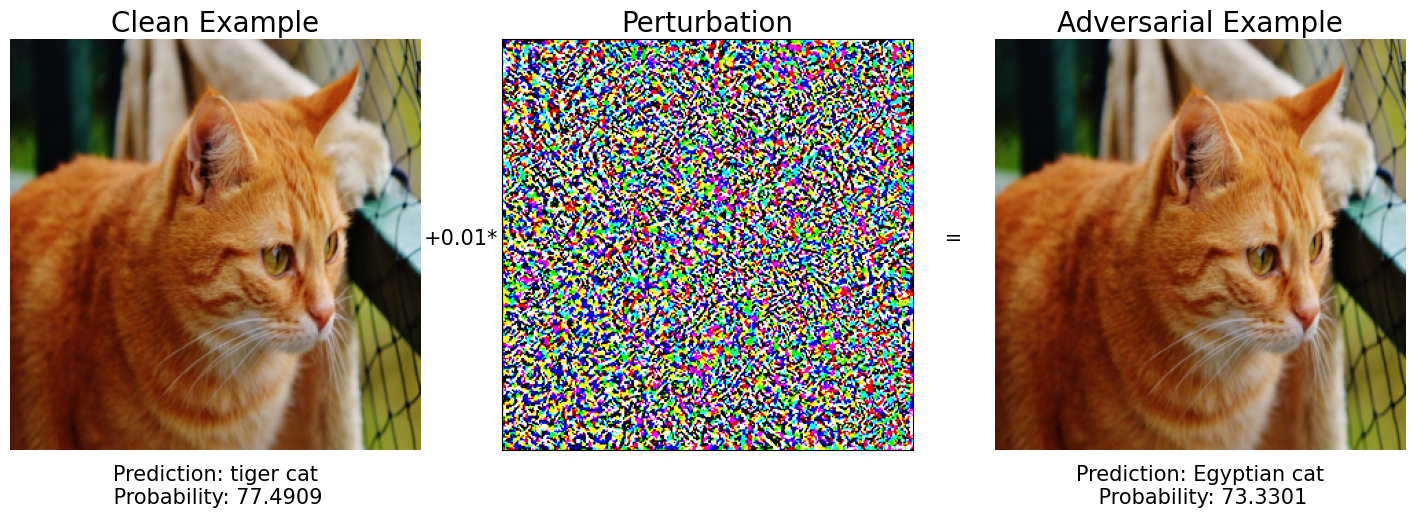

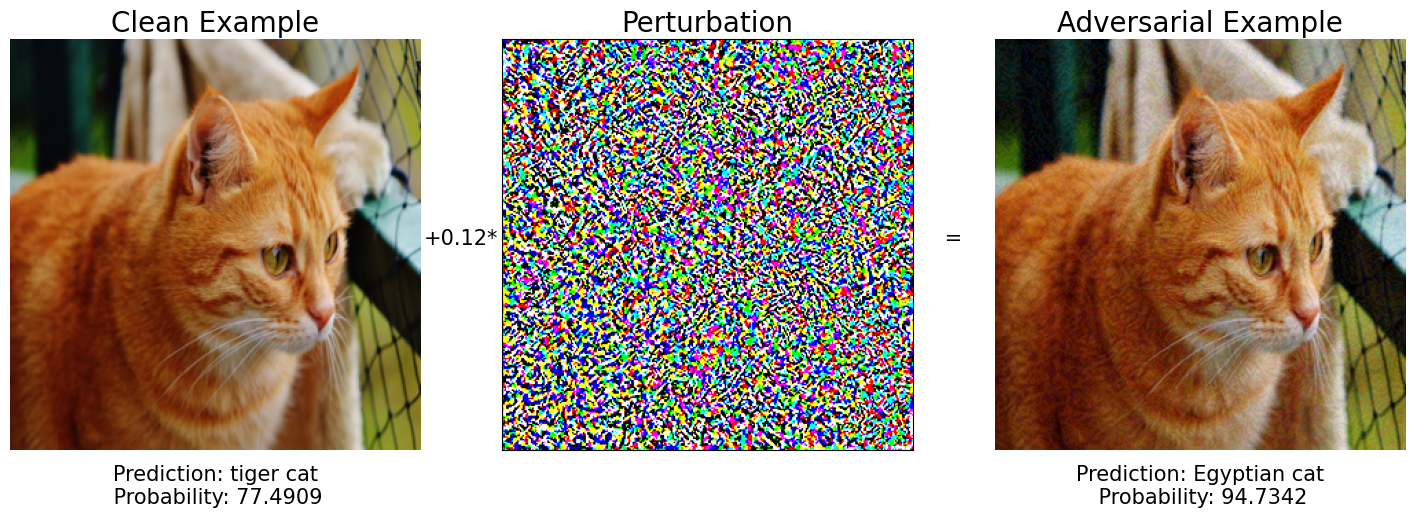

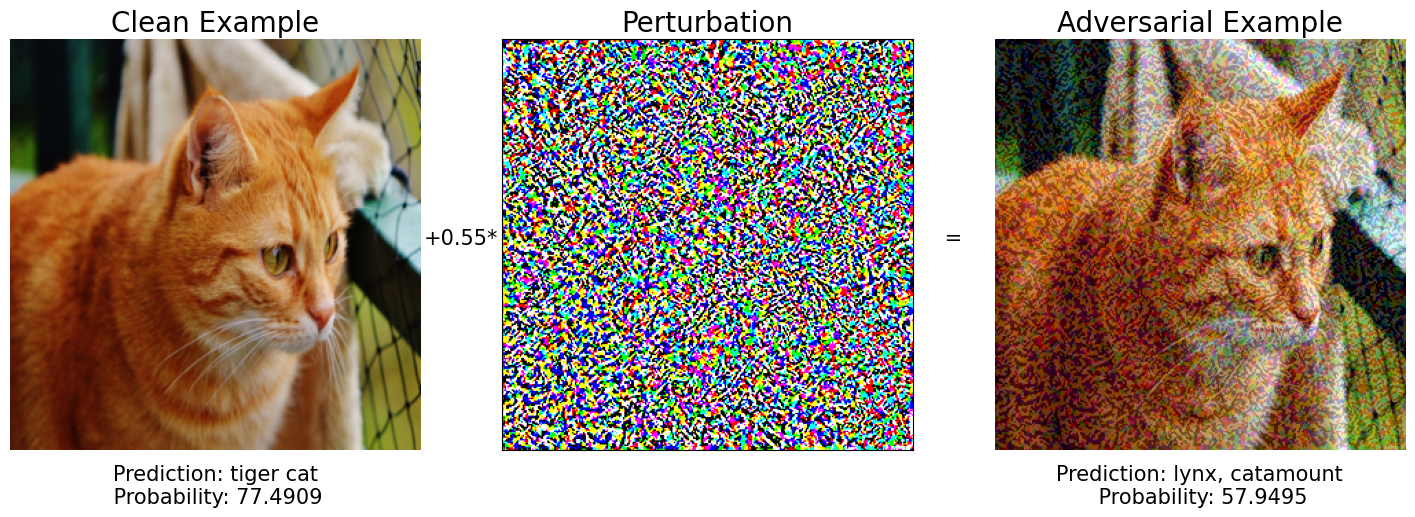

In [142]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilon:
  x_adversarial = img_variable.data + i * x_grad
  output_adv = inceptionv3.forward(Variable(x_adversarial))
  x_adv_pred = labels[torch.max(output_adv.data, 1)[1].numpy()[0]]
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0].numpy()[0]) * 100, 4)
  visualize(image_tensor, x_adversarial, mean, std, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)